## Training and Testing a Decision Tree Classifier model that trades Bitcoin

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier      # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics                          # Import scikit-learn metrics module for accuracy calculation
import talib
import random
from tqdm import tqdm
%matplotlib widget
# %matplotlib inline

# Read data from CSV
df = pd.read_csv("BTC_OHLCV_28Mar_14day.csv")
test_df = pd.read_csv("Train_test_data_new.csv").dropna()
df

Error: Canceled future for execute_request message before replies were done

In [5]:
def generate_indicators(df):
    df['diff_30'] = df['close'].diff(periods=30)
    df['diff_100'] = df['close'].diff(periods=100)
    df['diff_30MA'] = df['close'] - df['close'].rolling(window = 30).mean()
    df['diff_100MA'] = df['close'] - df['close'].rolling(window = 100).mean()
    df['RSI_100'] = talib.RSI(df.iloc[:, 1].values, timeperiod=100)
    df['MFI_100'] = talib.MFI(df['high'], df['low'], df['close'], df['volume'], timeperiod=100)
    df['volume_norm'] = df['volume']
    df['signal'] = 0
    df = df[100:]
    df = df.reset_index()
    for x in ['volume_norm', 'diff_30', 'diff_100', 'diff_30MA', 'diff_100MA', 'RSI_100', 'MFI_100']:
        df[x] = (df[x]-df[x].mean())/df[x].std()
    return df

In [6]:
def generate_signals(df, threshold):
    df['max_gain'] = df['close'].rolling(window = 240).max().shift(-240) - df['close']
    df['max_loss'] = df['close'] - df['close'].rolling(window = 240).min().shift(-240)

    # print(df['max_gain'].quantile([0.25,0.5,0.75,threshold]))
    # print(df['max_loss'].quantile([0.25,0.5,0.75,threshold]))
    buy_threshold = round(list(df['max_gain'].quantile([threshold]))[0])
    sell_threshold = round(list(df['max_loss'].quantile([threshold]))[0])

    df['signal'] = 0
    for i in range(0, len(df)-240):
        if df.at[i, 'max_gain'] > buy_threshold:
            df.at[i, 'signal'] = 1
        elif df.at[i, 'max_loss'] > sell_threshold:
            df.at[i, 'signal'] = -1
    
    return df

In [7]:
def plot_signals(df):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(df.index, df['close'], color='black', linewidth=1)
    ax.fill_between(df.index, min(df['close']), max(df['close']), where = df['signal'] == -1, facecolor='red', alpha=0.5)
    ax.fill_between(df.index, min(df['close']), max(df['close']), where = df['signal'] == 1, facecolor='green', alpha=0.5)
    plt.show()

In [13]:
def train_model(df, test_df = None, i=None):
    features = ['volume_norm', 'diff_100', 'diff_30MA', 'diff_100MA', 'MFI_100']
    x = df[features]
    y = df['signal']

    if test_df is None:         # 80% training and 20% test
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=False)
    else:
        X_train, X_test, y_train, y_test = df[features], test_df[features], df['signal'], test_df['signal']

    if not i:
        i = random.randint(1, 1000)
    clf = DecisionTreeClassifier(random_state=i)            # 80% training and 20% test
    clf = clf.fit(X_train,y_train)                          # Train Decision Tree Classifer
    y_pred = clf.predict(X_test)                            # Predict the response for test dataset

    # print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

    if test_df is None:
        df['signal_pred'] = 0
        df.iloc[-len(y_pred):]['signal_pred'] = y_pred
        return df.iloc[len(X_train):]
    else:
        test_df['signal_pred'] = 0
        test_df['signal_pred'] = y_pred
        return test_df
        # test_df.iloc[-len(y_pred):]['signal_pred'] = y_pred
        # return test_df.iloc[len(X_train):]

def simulate_trades(df):
    returns = {}
    df = df.reset_index()
    df['portfolio'] = 0
    df['trade'] = 0
    capital = 10000
    account = capital
    trade_size = 0.05 #BTC
    buys = 0
    sells = 0
    shares = 0
    for i in range(len(df)):
        if df['signal_pred'][i] == 1 and account > trade_size * df.iloc[i]['close']:
            account -= trade_size * df.iloc[i]['close']
            buys += 1
            shares += 1
            df.at[i, 'trade'] = 1
        elif df['signal_pred'][i] == -1 and shares > 0:
            account += trade_size * df.iloc[i]['close']
            sells += 1
            shares -= 1
            df.at[i, 'trade'] = -1
        df.at[i, 'portfolio'] = account + (buys - sells)*trade_size*df.iloc[i]['close']
            
    account += (buys - sells)*trade_size*df.iloc[-1]['close']
    returns['Starting capital'] = capital
    returns['Current account value'] = round(account, 2)
    returns['Percentage gain'] = str(round(((account / capital)-1) * 100, 2)) + '%'
    returns['Buys'] = buys
    returns['Sells'] = sells
    # print('starting capital:', capital)
    # print('current account value:', round(account, 2))
    # print('gain:', str(round(((account / capital)-1) * 100, 2)) + '%')
    # print('buys:', buys)
    # print('sells:', sells)
    return df, returns

def plot_trades(df):
    datetime_index = pd.DatetimeIndex(pd.to_datetime(df['time']))
    df = df.set_index(datetime_index).drop(['time'], axis=1)

    fig, axes = plt.subplots(2, figsize=(15,8), sharex=True)

    df['close'].plot(label= 'BTC-USD', ax=axes[0])
    df['portfolio'].plot(label= 'Portfolio value', color = 'orange', ax=axes[1])

    axes[0].scatter(df.index[df['trade'] == 1], 
                df['close'][df['trade'] == 1],
                marker='^', s = 25, color = 'lime', label = 'buy')

    axes[0].scatter(df.index[df['trade'] == -1],
                df['close'][df['trade'] == -1],
                marker='v', s = 25, color = 'r', label = 'sell')

    plt.ylabel('Price in USD', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title('BTC-USD trading model performance', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

In [14]:
test_df = generate_indicators(test_df)
df = generate_indicators(df)

In [15]:
test_df = generate_signals(test_df, 0.85)
df = generate_signals(df, 0.85)

In [16]:
plot_signals(test_df)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
total_returns = 0
for i in tqdm(range(50)):
    predictions_df = train_model(df, test_df, i)
    portfolio_df, returns = simulate_trades(predictions_df)
    total_returns += returns['Current account value']
print(total_returns/50)

100%|██████████| 50/50 [01:49<00:00,  3.05s/it]


9928.103999999998


In [22]:
predictions_df = train_model(df, test_df)
portfolio_df, returns = simulate_trades(predictions_df)
[print(key,':',value) for key, value in returns.items()]
plot_trades(portfolio_df)

Starting capital : 10000
Current account value : 9932.53
Percentage gain : -0.67%
Buys : 426
Sells : 421


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Starting capital : 10000
Current account value : 10531.18
Percentage gain : 5.31%
Buys : 875
Sells : 874


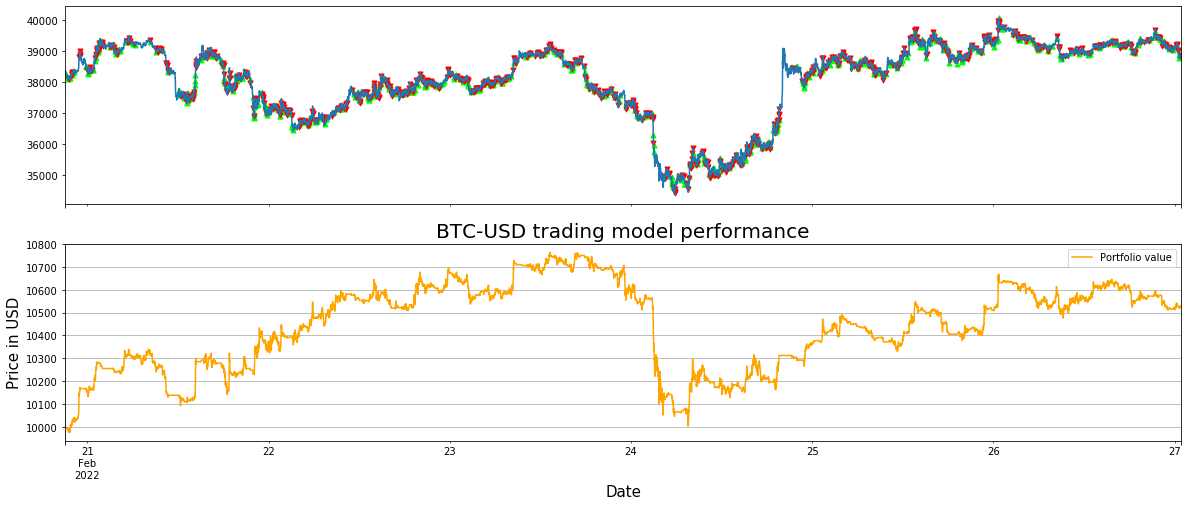

In [156]:
predictions_df = train_model(df, test_df, 95)
portfolio_df, returns = simulate_trades(predictions_df)
[print(key,':',value) for key, value in returns.items()]
plot_trades(portfolio_df)